In [1]:
!pip install torch_snippets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 K

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import PIL

from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch_snippets

import os
import time
import xml.etree.ElementTree as ET

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
def xml_to_dict(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    return {'filename': xml_path,
            "image_width": int(root.find("./size/width").text),
            "image_height": int(root.find("./size/height").text),
            "image_channels": int(root.find("./size/depth").text),
            "label": root.find("./object/name").text,
            "x1": int(root.find("./object/bndbox/xmin").text),
            "y1": int(root.find("./object/bndbox/ymin").text),
            "x2": int(root.find("./object/bndbox/xmax").text),
            "y2": int(root.find("./object/bndbox/ymax").text)}

In [4]:
# Convert human readable str label to int.
label_dict = {"keyboard": 1, "key": 2, "laptop": 3, "magnifying-glass":4, "mouse":5, "phone":6 }
# Convert label int to human readable str.
reverse_label_dict = {1: "keyboard", 2: "key", 3: "laptop", 4: "magnifying-glass", 5: "mouse", 6: "phone"}

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        """
        Inputs
            root: str
                Path to the data folder.
            transforms: Compose or list
                Torchvision image transformations.
        """
        self.root = root
        self.transforms = transforms
        self.files = [image[:-4] for image in sorted(os.listdir(root)) if image[-4:]=='.jpg']
        self.label_dict = label_dict
    def __getitem__(self, i):
        # Load image from the hard disc.
        img = PIL.Image.open(os.path.join(self.root, self.files[i] + ".jpg")).convert("RGB")
        # Load annotation file from the hard disc.
        ann = xml_to_dict(os.path.join(self.root, self.files[i] + ".xml"))
        # The target is given as a dict.
        target = {}
        target["boxes"] = torch.as_tensor([[ann["x1"], 
                                            ann["y1"], 
                                            ann["x2"], 
                                            ann["y2"]]], 
                                   dtype = torch.float32)
        target["labels"]=torch.as_tensor([label_dict[ann["label"]]],
                         dtype = torch.int64)
        target["image_id"] = torch.as_tensor(i)
        # Apply any transforms to the data if required.
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.files)

In [5]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms 
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [6]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

In [7]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [8]:
def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries.
    """
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y
def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [9]:
test_ds = ImageDataset("./data/test", get_transform(train = False))

In [10]:
# Randomly shuffle all the data.
indices = torch.randperm(len(test_ds)).tolist()
# We split the entire data into 80/20 train-test splits. We further
# split the train set into 80/20 train-validation splits. 
# Train dataset: 64% of the entire data, or 80% of 80%.
# train_ds = torch.utils.data.Subset(train_ds,
#            indices[:int(len(indices) * 0.64)])
# # Validation dataset: 16% of the entire data, or 20% of 80%.
# val_ds = torch.utils.data.Subset(val_ds, 
#          indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
# Test dataset: 20% of the entire data.
test_ds = torch.utils.data.Subset(test_ds, 
          indices[int(len(indices) * 0.8):])

In [11]:
# Collate image-target pairs into a tuple.
def collate_fn(batch):
    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets. 
# train_dl = torch.utils.data.DataLoader(train_ds, 
#                                  batch_size = 4, 
#                                  shuffle = True, 
#                         collate_fn = collate_fn)
# val_dl = torch.utils.data.DataLoader(val_ds, 
#                              batch_size = 4, 
#                             shuffle = False, 
#                     collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds, 
                               batch_size = 4, 
                              shuffle = False, 
                      collate_fn = collate_fn)

In [12]:
@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    X, _ = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions
def predict(model, data_loader, device = "cpu"):
    """
    Gets the predictions for a batch of data.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p
    
    return images, predictions

In [32]:
def decode_prediction(prediction, 
                      score_threshold = 0.1, 
                      nms_iou_threshold = 0.2):
    """
    Inputs
        prediction: dict
        score_threshold: float
        nms_iou_threshold: float
    Returns
        prediction: tuple
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    # Remove any low-score predictions.
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores, 
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    return (boxes.cpu().numpy(), 
            labels.cpu().numpy(), 
            scores.cpu().numpy())

In [15]:
import pickle

# Load from file
pkl_filename = "fasterrcnn_model2.pkl"
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

In [33]:
images, predictions = predict(model, test_dl, device)

The number of identified objects is 1


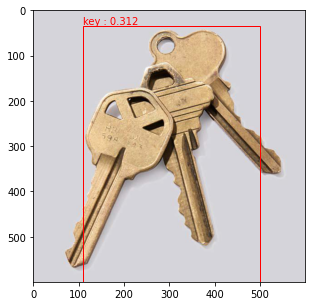

In [47]:
img_index = 3
boxes, labels, scores = decode_prediction(predictions[img_index])
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
print(f"The number of identified objects is {len(boxes)}")
plt.show()
